In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2

import numpy as np

In [14]:
##lable和image number对应的表
file_path = './UBC-OCEAN_CS640/train.csv'
df = pd.read_csv(file_path)
labels = df["label"]
print(labels)

0        CC
1        MC
2        CC
3        CC
4      HGSC
       ... 
425    HGSC
426    HGSC
427      MC
428      EC
429      CC
Name: label, Length: 430, dtype: object


In [15]:
#假设图片是imgs[id]，label是labels[id]
#那图片的输出路径就是path_to_img="/".join(/projectnb/cs640grp/students/cxxiong/UBC-OCEAN_CS640/labeled_train_data, labels[id], id)

In [16]:
def list_files_in_directory(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

directory_path = './UBC-OCEAN_CS640/train_images_compressed_80'
file_paths = list_files_in_directory(directory_path)

for file_path in file_paths:
    print(file_path)

./UBC-OCEAN_CS640/train_images_compressed_80\10077.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10143.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10252.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10469.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10548.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10642.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\1080.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\10896.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\11263.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\11417.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\11431.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\11557.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\11559.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\12222.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\12244.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\12442.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\1252.jpg
./UBC-OCEAN_CS640/train_images_compressed_80\12522.jpg
./UBC-OCEAN_

In [17]:
len(file_paths)

430

In [18]:
def extract_between_chars(input_str, start_char, end_char):
    start_index = input_str.find(start_char)
    end_index = input_str.find(end_char, start_index + 1)  # 在 start_index 之后找 end_char

    if start_index != -1 and end_index != -1:
        result = input_str[start_index + len(start_char):end_index]
        return result
    else:
        return None
results = []
for paths in file_paths:    
    result = extract_between_chars(paths, "80\\", ".jpg")
    results.append(int(result))
print(results)

[10077, 10143, 10252, 10469, 10548, 10642, 1080, 10896, 11263, 11417, 11431, 11557, 11559, 12222, 12244, 12442, 1252, 12522, 1289, 12902, 1295, 13364, 13387, 13526, 13987, 14039, 14051, 14127, 14312, 14401, 14424, 14532, 14542, 14617, 15139, 15188, 15209, 15221, 15231, 15293, 15470, 15486, 15583, 15671, 15742, 16042, 16064, 16209, 16325, 16494, 1666, 16876, 16986, 17067, 17174, 17291, 17365, 17416, 17487, 17637, 17738, 1774, 17854, 18014, 18138, 18547, 18607, 18810, 18813, 18896, 18981, 19030, 19157, 1925, 19255, 1952, 19569, 20205, 20312, 20329, 20670, 20858, 20882, 2097, 21020, 21232, 21303, 21373, 21432, 21445, 21910, 21929, 22155, 22221, 2227, 22290, 22425, 22489, 22654, 22740, 22924, 23523, 23796, 2391, 24023, 24507, 24563, 24617, 24759, 24991, 25561, 25604, 25792, 25928, 26025, 26124, 26190, 26533, 26603, 26644, 2666, 26862, 26950, 2706, 27245, 27249, 27315, 27747, 27851, 27950, 28028, 28066, 281, 28121, 28393, 28519, 28562, 28603, 28736, 28821, 28922, 2906, 29084, 29147, 29200, 

In [19]:
imgset = pd.DataFrame({'path': file_paths, 'image_id': results})
merged_data = pd.merge(imgset, df, on='image_id', how='left')
#csv_path = '/projectnb/cs640grp/students/cxxiong/UBC-OCEAN_CS640/labeled_train_data/merged_data.csv'
#merged_data.to_csv(csv_path, index=False)


In [20]:
def map_label_id(label):
    if label == 'CC':
        return 0
    elif label == 'EC':
        return 1
    elif label == 'HGSC':
        return 2
    elif label == 'LGSC':
        return 3
    elif label == 'MC':
        return 4
    else:
        return -1  # 如果有其他 label，你可以设置一个默认值或者根据需求设定

# 使用 apply 方法将函数应用到 DataFrame 的 label 列，并创建新的 label_id 列
merged_data['label_id'] = merged_data['label'].apply(map_label_id)

In [21]:
img_size = 224
train = []
#for i in range(len(file_paths)-1):
for i in range(50):
    print(i)
    img_arr = cv2.imread(merged_data.iloc[i,0])[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    train.append([resized_arr,merged_data.iloc[i,3]])

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [38]:
val = []
for i in range(70,100):
    print(i)
    img_arr = cv2.imread(merged_data.iloc[i,0])[...,::-1] #convert BGR to RGB format
    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
    val.append([resized_arr,merged_data.iloc[i,3]])

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 1.0, '2')

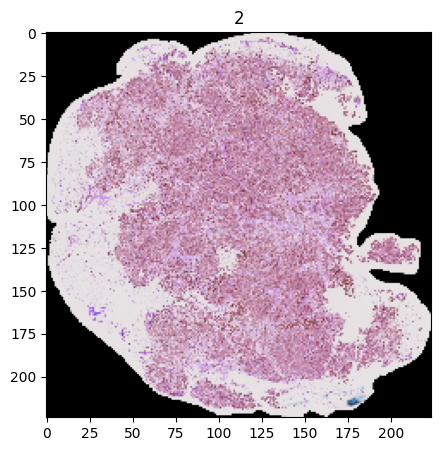

In [23]:
#可视化随机图像
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(train[1][1])

In [24]:
#数据预处理和增强
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [25]:
#对训练数据的增强
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [32]:
#让我们定义一个简单的CNN模型，有3个卷积层，然后是max-pooling层。在第3次maxpool操作后添加一个dropout层，以避免过度拟合
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(5, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 64)       

In [33]:
#现在让我们使用Adam作为优化器，SparseCategoricalCrossentropy作为损失函数来编译模型。我们使用较低的学习率0.000001来获得更平滑的曲线。
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [34]:
#现在，让我们训练我们的模型500个epochs，因为我们的学习速率非常小。
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


c:\All\Coding\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2/2 [==============================] - 5s 1s/step - loss: 1.6081 - accuracy: 0.2400 - val_loss: 1.5706 - val_accuracy: 0.3000
Epoch 2/500
2/2 [==============================] - 1s 371ms/step - loss: 1.6048 - accuracy: 0.1800 - val_loss: 1.5686 - val_accuracy: 0.3000
Epoch 3/500
2/2 [==============================] - 1s 389ms/step - loss: 1.5933 - accuracy: 0.2000 - val_loss: 1.5669 - val_accuracy: 0.2500
Epoch 4/500
2/2 [==============================] - 1s 332ms/step - loss: 1.5768 - accuracy: 0.2400 - val_loss: 1.5653 - val_accuracy: 0.2500
Epoch 5/500
2/2 [==============================] - 1s 325ms/step - loss: 1.6017 - accuracy: 0.2200 - val_loss: 1.5638 - val_accuracy: 0.2000
Epoch 6/500
2/2 [==============================] - 1s 353ms/step - loss: 1.5518 - accuracy: 0.3800 - val_loss: 1.5625 - val_accuracy: 0.2000
Epoch 7/500
2/2 [==============================] - 1s 333ms/step - loss: 1.5718 - accuracy: 0.2800 - val_loss: 1.5612 - val_accuracy: 0.2000
Epoch 8/500
2/2 [===========

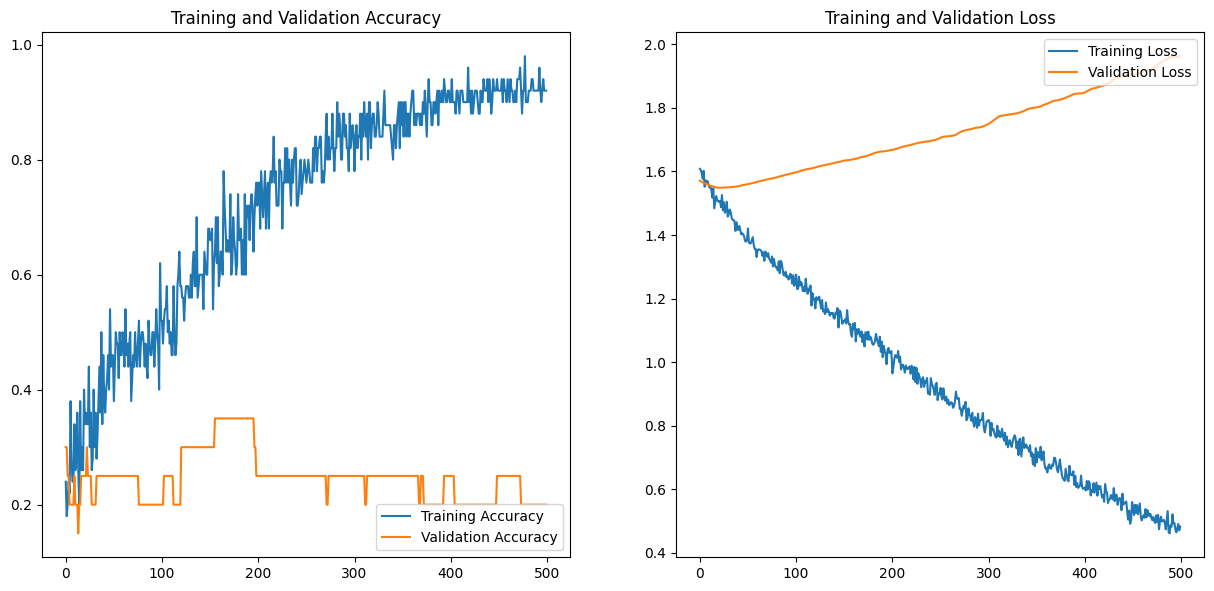

In [37]:
#我们将绘制我们的训练和验证的准确性以及训练和验证的损失。
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
#我们可以打印出分类报告，看看精度和准确性
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
#迁移学习
#步骤1: 导入模型
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
#冻结模型
base_model.trainable = False
#接下来，我们使用base_model定义模型，然后使用GlobalAveragePooling函数将每个图像的特征转换为单个矢量。我们添加0.2的dropout和最终的全连接层，有2个神经元和softmax激活。
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])
#接下来，让我们编译模型并开始训练它。
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

In [ ]:
#步骤2: 评估结果
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#打印分类报告
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))